pip install of torch geometric module for graph neural network usage.

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 848.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.9 MB/s eta 0:00:00


Full imports.

In [ ]:
import os;
from copy import deepcopy;
import random;
import networkx as nx;
import pandas as pd;
import numpy as np;
import torch;
from torch.nn import Linear, Conv1d, LSTM, AdaptiveAvgPool1d, Dropout;
from torch.nn.functional import relu;
from torch_geometric.nn import MessagePassing, GATConv;
from torch_geometric.data import Data;
from torch_geometric.loader import DataLoader;
from torch.optim.lr_scheduler import ReduceLROnPlateau;
import matplotlib.pyplot as plt;
from mpl_toolkits.mplot3d import Axes3D;

In [ ]:
from google.colab import drive;
drive.mount('/content/drive');

Mounted at /content/drive


In [ ]:
def load_amino_acid_labels(csv_file, amino_acids):
    """
    Loads amino acid labels from a CSV file.

    Parameters
    ----------
    csv_file : The csv file in the directory to be processed.
    amino_acids : The constant

    Returns
    -------
    Returns the one-hot encoded amino acid features (sequence).

    """

    seq = pd.read_csv(csv_file, header=None);
    # One-hot encoding for amino acid features.
    seq = seq[0].to_numpy();
    aa_to_OH = [];
    for i, j in enumerate(seq):
        aa_to_OH.append(amino_acids[j]);
    aa_tensor = torch.tensor(aa_to_OH, dtype=torch.float);
    return aa_tensor;

In [ ]:
def load_graph(graph_file):
    """
    Loads the molecular graph of the protein from the graph file.

    Parameters
    ----------
    graph_file: The graph file in the directory to be processed.

    Returns
    -------
    Returns the networkx graph containing the nodes and their related edges.

    """
    # Utilises the networkx read_graphml function to extract nodes & edges.
    graph = nx.read_graphml(graph_file);
    node_data = [];
    # Necessary to remove strings from the tensor data.
    for node, coord in graph.nodes(data=True):
        node_index = int(node);
        coords = [coord['coordX'], coord['coordY'], coord['coordZ']];
        # Combines the integer node with its corresponding coordinate floats.
        node_data.append([node_index] + coords);
    # Resulting 32 bit float tensor:
    node_tensor = torch.tensor(node_data, dtype=torch.float);
    edge_data = [];
    edge_weight = [];
    # Similar operation for the edge list.
    for source, target, weight in graph.edges(data=True):
        # Combines the edge with its corresponding weighting.
        edge_data.append([int(source) - 1, int(target) - 1]);
        edge_weight.append(float(weight['weight']));
        # Making the graph undirected:
        edge_data.append([int(target) - 1, int(source) - 1]);
        edge_weight.append(float(weight['weight']));
    # Resulting 32 bit float tensor:
    edge_tensor = torch.tensor(edge_data, dtype=torch.long);
    # Creating weight tensor for edge attribution.
    weight_tensor = torch.tensor(edge_weight, dtype=torch.float);

    return node_tensor, edge_tensor, weight_tensor;

In [ ]:
def integrate_labels_and_graphs(directory=r'dataset/AlphaFold Protein Database e.coli/Uncompressed/graphs/graphML'):
    """
    Combines CSV and graphs into PyTorch Geometric Data objects across
    directory by calling load_amino_acid_labels and load_graph6/sparse6/graphml.

    Parameters
    ----------
    directory : The path to the directory containing the file pairings.
    -Default: r'dataset/AlphaFold Protein Database e.coli/Uncompressed/graphs/graphML'.

    Returns
    -------
    data_list : The geometric data of one-hot encoded amino acid sequences and
    atomic node.
    amino_acids : The list of amino acids

    """

    # Creating a dict for one-hot encoding amino acids to a numeric value.
    amino_acids = [
        'ALA', 'ARG', 'ASN', 'ASP', 'CYS',
        'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
        'LEU', 'LYS', 'MET', 'PHE', 'PRO',
        'SER', 'THR', 'TRP', 'TYR', 'VAL',
        'PYL', 'SEC'
        ];
    AA_onehot = {aa : i for i, aa in enumerate(set(amino_acids))};

    # Initialising array.
    data_list = [];
    # Iterates over the entire directory of file-pairings.
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.csv'):
            # Taking the file name without the extension.
            base_name = file_name.split('AAlabel.csv')[0];
            csv_file = os.path.join(directory, file_name);
            graph_file = os.path.join(directory, f'{base_name}gcn_graph.graphml');
            # Checking the graph file path's validity.
            if os.path.exists(graph_file):
                print(f'Valid path to: {graph_file}');
                AA_labels = load_amino_acid_labels(csv_file, AA_onehot);
                node_list, edge_list, weight_list = load_graph(graph_file);
                data = Data(x=node_list,
                            edge_index=edge_list.t().contiguous(),
                            edge_attr=weight_list.contiguous(),
                            y=AA_labels);
                data_list.append(data);
                if len(data_list) % 10 == 0:
                    print(f'Processed {len(data_list)} entries');
    return data_list;

CNN based model.

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__();
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=2048,
                                     kernel_size=20, stride=10);
        self.conv2 = torch.nn.Conv1d(in_channels=2048, out_channels=1024,
                                     kernel_size=40, stride=20);
        self.pool = torch.nn.AdaptiveAvgPool1d(output_size=1024);
        self.fc = torch.nn.Linear(in_features=1024, out_features=4);

    def forward(self, data):
        data.y = data.y.unsqueeze(0);
        z = self.conv1(data.y);
        z = relu(z);
        z = self.conv2(z);
        z = relu(z);
        z = self.pool(z);
        return self.fc(z);

In [ ]:
# Additional layers to contrast with the first CNN model.
class drop_CNN(torch.nn.Module):
    def __init__(self):
        super().__init__();
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=1024,
                                     kernel_size=50, stride=25);
        self.conv2 = torch.nn.Conv1d(in_channels=1024, out_channels=2048,
                                     kernel_size=50, stride=15);
        self.conv3 = torch.nn.Conv1d(in_channels=2048, out_channels=4096,
                                     kernel_size=50, stride=25);
        self.pool = torch.nn.AdaptiveAvgPool1d(output_size=2048);
        self.dropout = torch.nn.Dropout(p=0.3);
        self.fc = torch.nn.Linear(in_features=2048, out_features=4);

    def forward(self, data):
        data.y = data.y.unsqueeze(0);
        z = self.conv1(data.y);
        z = relu(z);
        z = self.conv2(z);
        z = self.dropout(z);
        z = relu(z);
        z = self.conv3(z);
        z = self.dropout(z);
        z = relu(z);
        z = self.pool(z);
        return self.fc(z);

(NLP) LSTM based model.

In [ ]:
class LSTM_model(torch.nn.Module):
    def __init__(self):
        super().__init__();
        self.lstm = torch.nn.LSTM(input_size=1, hidden_size=512,
                                  num_layers=1, batch_first=True,
                                  bidirectional=True);
        self.pool = torch.nn.AdaptiveAvgPool1d(output_size=1024);
        self.fc = Linear(in_features=1024, out_features=4);

    def forward(self, data):
        data.y = data.y.unsqueeze(0).unsqueeze(2);
        h0=torch.zeros(1*2, data.y.size(0), 512);
        c0=torch.zeros(1*2, data.y.size(0), 512);
        z, _ = self.lstm(data.y, (h0, c0));
        z = self.pool(z);
        z = self.fc(z);
        return z.squeeze(0);

Graphical Neural Network model.

In [ ]:
class GNN(MessagePassing):
    def __init__(self):
        super().__init__();
        self.lstm=torch.nn.LSTM(input_size=1, hidden_size=512,
                                  num_layers=1, batch_first=True,
                                  bidirectional=True);
        self.fc1=Linear(in_features=1024, out_features=1024);
        self.conv=GATConv(in_channels=2048,
                           out_channels=2048);
        self.pool=torch.nn.AdaptiveAvgPool1d(output_size=1024);
        self.fc2=Linear(in_features=1024,
                        out_features=4);


    def forward(self, data):
        data.y = data.y.unsqueeze(0);
        h0=torch.zeros(1*2, data.y.size(0), 2048);
        c0=torch.zeros(1*2, data.y.size(0), 2048);
        edge_index = self.lstm(data.y, (h0, c0));
        edge_weight = self.fc1(edge_index);
        z = self.conv(data.y, edge_index, edge_weight);
        z = relu(z);
        z = self.pool(z);
        return self.fc2(z);

Model testing/validation function.

In [ ]:
def test_model(loader, model, criterion=torch.nn.MSELoss()):

    model.eval();
    total_loss=0;
    for data in loader:
        # Send data to the GPU.
        data = data.to(device);
        data_test = deepcopy(data);
        data_test.x * 0;
        # Mask edge index with self loops.
        # Take the number of nodes from the x value of Data object.
        num_nodes = data_test.x.shape[0];
        # Creates a dummy tensor with all the node values and dupes for self loop.
        data_test.edge_index = torch.arange(num_nodes).repeat(2, 1);
        # Mask edge attribute values (weight) with nullification (multiplied by 0).
        data_test.edge_attr = torch.tensor([0]);
        data_test = data_test.to(device);
        node_out = model(data_test);
        if node_out.shape[0] != data_test.x.shape[0]:
            if node_out.shape[0] > data_test.x.shape[0]:
                padding = torch.zeros((node_out.shape[0] - data_test.x.shape[0], 4));
                data_test.x = torch.cat((data_test.x, padding), dim=0);
            else:
                padding = torch.zeros((data.x.shape[0] - node_out.shape[0], 4));
                node_out = torch.cat((node_out, padding), dim=0);
        loss = criterion(node_out, data.x);
        total_loss += loss.item();
    return total_loss / len(loader), node_out;

Model training function.

In [ ]:
def train_model(loader, model, optimizer, criterion=torch.nn.MSELoss()):

    model.train();
    total_loss=0;
    for data in loader:
        # Sending data to the GPU for memory availability purposes.
        data = data.to(device);
        optimizer.zero_grad();
        node_out = model(data);
        if node_out.shape[0] != data.x.shape[0]:
            if node_out.shape[0] > data.x.shape[0]:
                padding = torch.zeros((node_out.shape[0] - data.x.shape[0], 4));
                data.x = torch.cat((data.x, padding), dim=0);
            else:
                padding = torch.zeros((data.x.shape[0] - node_out.shape[0], 4));
                node_out = torch.cat((node_out, padding), dim=0);
        loss = criterion(node_out, data.x);
        loss.backward();
        optimizer.step();
        total_loss += loss.item();
    return total_loss / len(loader);

Function which wraps up training/validation and metric plotting.

In [ ]:
def process(loader, model, epochs=10,
            chosen_opt=torch.optim.Adam, learn_rate=0.02):

    optimizer=chosen_opt(model.parameters(), lr=learn_rate);
    scheduler=ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1,
                                patience=4, threshold=100, threshold_mode='abs',
                                cooldown=0, min_lr=0, eps=1e-8);
    model.to(device);
    # Initialising variables for metric plotting and saving model state.
    best_state_dict = deepcopy(model.state_dict());
    train_loss_record = [];
    val_loss_record = [];
    loss_difference = -1;
    # Training over epochs.
    for epoch in range(epochs):
        avg_loss = train_model(loader[0], model, optimizer=optimizer);
        train_loss_record.append(avg_loss);
        # Only the loss from the test_model function is needed here.
        val_mse, _ = test_model(loader[1], model);
        val_loss_record.append(val_mse);
        print(f'Epoch {epoch+1}, '\
              f'\nAverage MSE training loss: {avg_loss:.4f}'\
                  f'\nAverage MSE validation loss: {val_mse:.4f}');
        scheduler.step(avg_loss);
        if abs(avg_loss - val_mse) <= 1.5*loss_difference \
        and abs(avg_loss - val_mse) >=0:
            loss_difference = abs(avg_loss - val_mse);
            best_state_dict = deepcopy(model.state_dict());
    directory = r'/content/drive/MyDrive/Herts_Uni/Final_Project/model_state_dict/';
    file_name = f'{model.__class__.__name__}.pt';
    torch.save(best_state_dict, os.path.join(directory, file_name));

    fig, ax = plt.subplots(dpi=144);
    upper_y_limit = np.max([np.sort(train_loss_record)[-2],
                            np.sort(val_loss_record)[-2]]);
    lower_y_limit = np.min([np.sort(train_loss_record)[0],
                            np.sort(val_loss_record)[0]]);
    text_placement = lower_y_limit * 0.995;
    ax.set_title(f'{model.__class__.__name__} model loss');
    ax.plot(train_loss_record, label='Training loss');
    ax.plot(val_loss_record, label='Validation loss');
    ax.grid(visible=True, which='both', linestyle=':');
    ax.set_xlabel('Epoch');
    ax.set_xticks(np.arange(0, epochs, step=1),
                  labels=np.arange(1, epochs+1, step=1).astype(str));
    ax.set_xlim(-1, epochs);
    ax.set_ylabel('MSE loss (average over batch) (Angstroms)');
    ax.set_ylim(lower_y_limit*0.999,
                upper_y_limit*1.001);
    ax.text(x=7, y=text_placement,
            s=f'Highest train loss \nvalue: {np.sort(train_loss_record)[-1]}',
            horizontalalignment='left', verticalalignment='top', fontsize=8);
    ax.legend(loc='upper right');
    plt.show();

Function for visualisation of the model's predictions against the true data's
visualisation.

In [ ]:
def structure_visualisation(loader, model):
    state_dict = torch.load(f'/content/drive/MyDrive/Herts_Uni/Final_Project/' \
                            'model_state_dict/{model.__class__.__name__}.pt');
    model.load_state_dict(state_dict);
    _, predictions = test_model(loader, model);
    fig, ax = plt.subplots(dpi=144, projection='3d');
    ax.set_title(f'{model.__class__.__name__} model spatial prediction');
    ax.plot_surface(X=predictions[1], Y=predictions[2], Z=predictions[3]);
    ax.set_xlabel('X dimension');
    ax.set_ylabel('Y dimension');
    ax.set_zlabel('Z dimension');
    ax.view_init(elev=30.);

Running the program.

In [ ]:
# Setting suitable (GPU) for model training/evaluation if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');
print(f'Using {device} for training & testing.');

Using cpu for training & testing.


In [ ]:
# For validity of presented figures in report.
random.seed(6525);
data_list = integrate_labels_and_graphs(directory=r'/content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML');
print(f'Processed {len(data_list)} file pairings into PyTorch Geometric Data objects.');
# Shuffling the Data objects' order in the list.
random.shuffle(data_list);

Valid path to: /content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML/AF-A0A385XJ53-F1-model_v4-gcn_graph.graphml
Valid path to: /content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML/AF-A0A385XJE6-F1-model_v4-gcn_graph.graphml
Valid path to: /content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML/AF-A0A385XJK5-F1-model_v4-gcn_graph.graphml
Valid path to: /content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML/AF-A0A385XJL2-F1-model_v4-gcn_graph.graphml
Valid path to: /content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML/AF-A0A385XJL4-F1-model_v4-gcn_graph.graphml
Valid path to: /content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML/AF-A0A385XJN2-F1-model_v4-gcn_graph.graphml
Valid path to: /content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML/AF-A0A385XK32-F1-model_v4-gcn_graph.graphml
Valid path to: /content/drive/MyDrive/Herts_Uni/Final_Project/graphs/graphML/AF-A5A605-F1-model_v4-gcn_graph.graphml
Valid path to: /content/drive/MyDriv

In [ ]:
# Creating parameters for train/validation/test split.
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1;
train_size = int(train_ratio * len(data_list));
val_size = int(val_ratio * len(data_list));
# Creating the split lists.
train_data = data_list[:train_size];
# Sliced from the end of the train set to itself + the validation set.
val_data = data_list[train_size:train_size + val_size];
# Sliced from the end of the validation set to the end of full set.
test_data = data_list[train_size + val_size:];
# Creating the loaders for each split.
train_loader = DataLoader(train_data, batch_size=256);
val_loader = DataLoader(val_data, batch_size=256);
test_loader = DataLoader(test_data, batch_size=256);

Epoch 1, 
Average MSE training loss: 23372.9899
Average MSE validation loss: 24147.7231
Epoch 2, 
Average MSE training loss: 23367.2547
Average MSE validation loss: 24145.7041
Epoch 3, 
Average MSE training loss: 23366.5396
Average MSE validation loss: 24143.8882
Epoch 4, 
Average MSE training loss: 23366.6942
Average MSE validation loss: 24142.6255
Epoch 5, 
Average MSE training loss: 23366.1123
Average MSE validation loss: 24142.0757
Epoch 6, 
Average MSE training loss: 23365.3009
Average MSE validation loss: 24140.5444
Epoch 7, 
Average MSE training loss: 23364.6593
Average MSE validation loss: 24141.3613
Epoch 8, 
Average MSE training loss: 23364.5189
Average MSE validation loss: 24141.0044
Epoch 9, 
Average MSE training loss: 23364.3188
Average MSE validation loss: 24140.2422
Epoch 10, 
Average MSE training loss: 23364.2228
Average MSE validation loss: 24140.3633


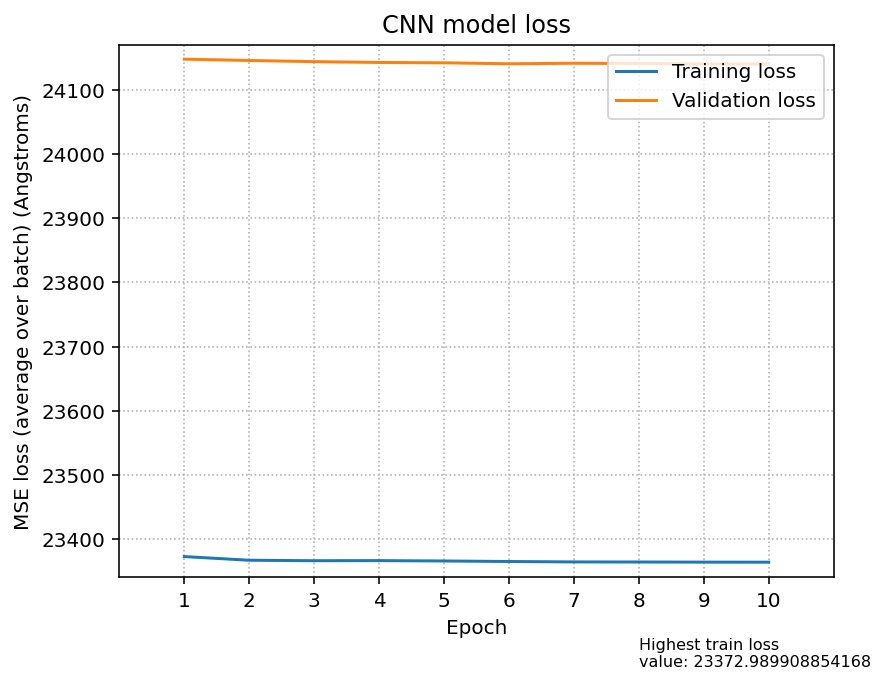

In [ ]:
# Training loop for the CNN model.
process(loader=[train_loader, val_loader], model=CNN(), epochs=10,
        learn_rate=0.001);

Epoch 1, 
Average MSE training loss: 27091.7235
Average MSE validation loss: 24149.2554
Epoch 2, 
Average MSE training loss: 23369.4844
Average MSE validation loss: 24149.1748
Epoch 3, 
Average MSE training loss: 23369.3846
Average MSE validation loss: 24149.0908
Epoch 4, 
Average MSE training loss: 23369.3211
Average MSE validation loss: 24149.0044
Epoch 5, 
Average MSE training loss: 23369.2601
Average MSE validation loss: 24148.9194
Epoch 6, 
Average MSE training loss: 23369.1955
Average MSE validation loss: 24148.8340
Epoch 7, 
Average MSE training loss: 23369.1310
Average MSE validation loss: 24148.7485
Epoch 8, 
Average MSE training loss: 23369.0924
Average MSE validation loss: 24148.7402
Epoch 9, 
Average MSE training loss: 23369.0861
Average MSE validation loss: 24148.7305
Epoch 10, 
Average MSE training loss: 23369.0806
Average MSE validation loss: 24148.7227


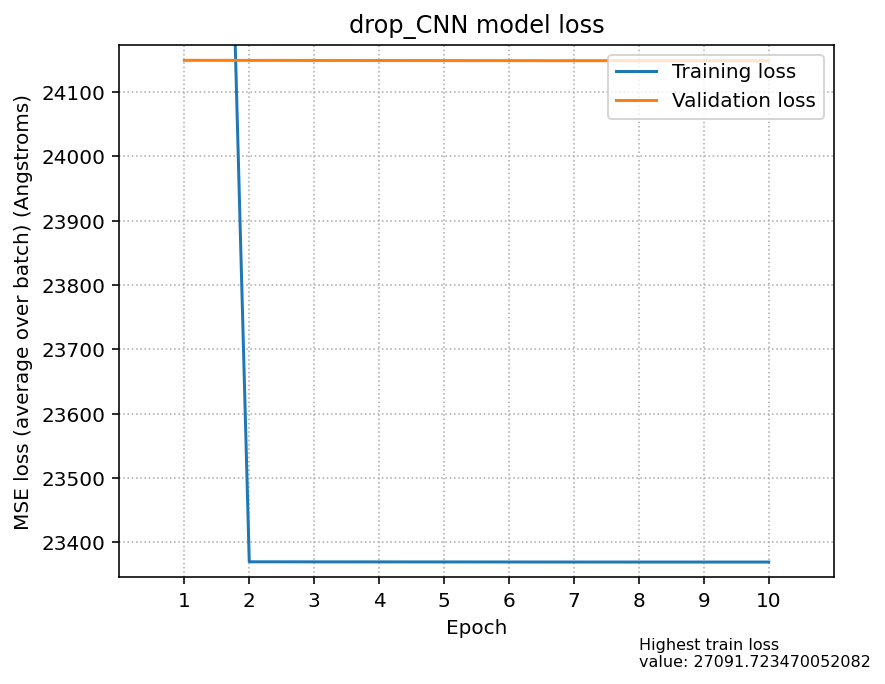

In [ ]:
# Training loop for the dropout CNN model.
process(loader=[train_loader, val_loader], model=drop_CNN(), epochs=10,
        learn_rate=0.001);

Epoch 1, 
Average MSE training loss: 17840.8477
Average MSE validation loss: 13610.4709
Epoch 2, 
Average MSE training loss: 11745.2004
Average MSE validation loss: 10963.2722
Epoch 3, 
Average MSE training loss: 11015.7396
Average MSE validation loss: 11053.8398
Epoch 4, 
Average MSE training loss: 11018.8039
Average MSE validation loss: 10944.8574
Epoch 5, 
Average MSE training loss: 10899.7337
Average MSE validation loss: 10975.7981
Epoch 6, 
Average MSE training loss: 10907.8266
Average MSE validation loss: 10974.0886
Epoch 7, 
Average MSE training loss: 10904.3761
Average MSE validation loss: 10952.5483
Epoch 8, 
Average MSE training loss: 10900.4775
Average MSE validation loss: 10950.8313
Epoch 9, 
Average MSE training loss: 10900.4894
Average MSE validation loss: 10954.6863
Epoch 10, 
Average MSE training loss: 10901.6973
Average MSE validation loss: 10956.5938


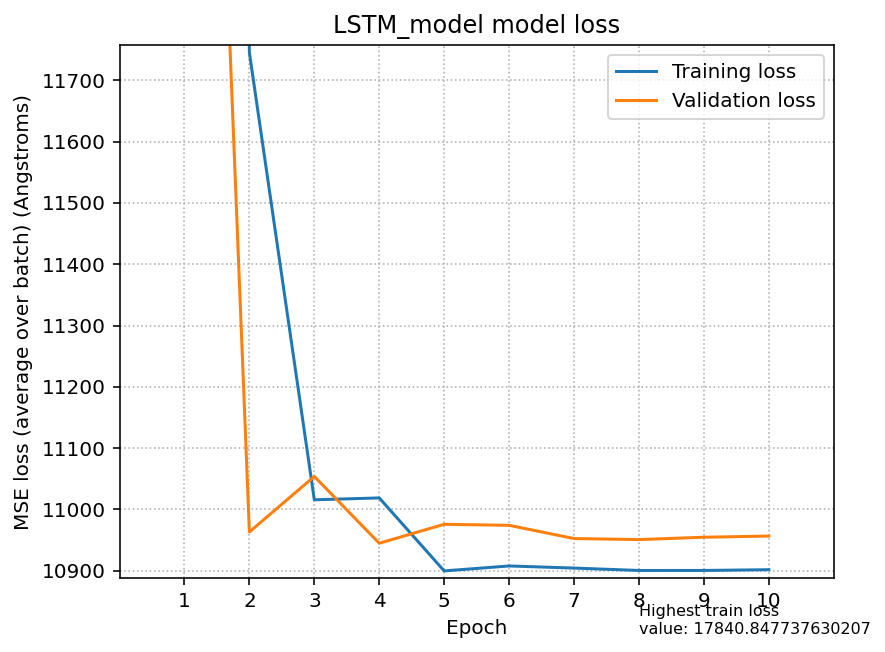

In [ ]:
# Training loop for the LSTM model.
process(loader=[train_loader, val_loader], model=LSTM_model(), epochs=10);

In [ ]:
# Training loop for the GNN model.
process(loader=[train_loader, val_loader], model=GNN(), epochs=10);